In [95]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [96]:
from enum import Enum

class PatternSpaceType(Enum):
    AXIS_ALIGNED_HYPER_RECTANGLES = 1
    HALF_SPACES = 2

class PatternSpace:
    def __init__(self, type: PatternSpaceType, cutoff: float = 0):
        self.type = type
        self.cutoff = cutoff


import pyomo.environ as pyo
import numpy as np
#from rare_pattern_detect.patterns import PatternSpace


def contains(point: np.ndarray, largest_bounding_area) -> bool:
    return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

def minlp_has_rare_pattern(
    x, training_data, pattern_space: PatternSpace, mu, debugging_minlp_model=False
):
    min_area = pattern_space.cutoff  # @TODO: Replace with dynamic area calculation
    model = MINLPModel(training_data, min_area)

    # Checking if point is included in the largest bounding area defined by the training set
    if contains(x, model.largest_bounding_area):
        solution = model.classify(x, debugging_minlp_model)

        # Parse solution output
        if solution is not None: 
            # If the minlp model was feasible and a solution was found 
            # then we return the model and the label that contains 
            # if the point is anomalous or not (bool)
            res = (model, solution <= mu)
        else:
            # If for some reasons the model encountered an error 
            # while trying to solve the minlp model
            print("Error when classifying a point: ", x, model.largest_bounding_area)
            res = (None, None)
    else:
        print("point to be classified outside of the limits: anomaly")
        # no need to solve the minlp model for this point.
        # Since the point lies outside of the largest point area, then it must be an anomaly (True)
        res = (None, True)

    return res
        

class MINLPModel:
    def __init__(self, training_set: np.array, min_area: float):
        self.training_set = training_set  # a N x d matrix
        self.min_area = min_area  # the smallest allowed area
        self.N, self.d = self.training_set.shape
        self.Nrange, self.drange = (range(x) for x in self.training_set.shape)
        self.largest_bounding_area = np.array(
            [
                [np.min(self.training_set[:, 0]), np.min(self.training_set[:, 1])],
                [np.max(self.training_set[:, 0]), np.max(self.training_set[:, 1])],
            ]
        )
        self.model = self.create_model()
        self.minimized_f_hats = np.zeros(self.N, float)

    def create_model(self):
        def _pattern_area():
            return pyo.prod(model.interval_lengths[i] for i in self.drange)

        # define model
        model = pyo.ConcreteModel()

        ## variables

        # x is a 2d vector
        model.pattern = pyo.Var(self.drange , self.drange) #  , bounds=adjust_largest_pattern_bounds)

        # y is a boolean vector of size N
        model.included = pyo.Var(self.Nrange, within=pyo.Binary, initialize=0)

        # auxiliary variables
        model.interval_lengths = pyo.Var(self.drange, within=pyo.NonNegativeReals)
        model.point_left_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )
        model.point_right_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )

        ## objective (minimised by default)
        model.obj = pyo.Objective(
            expr=sum(model.included[i] for i in self.Nrange) / _pattern_area(),
            sense=pyo.minimize,
        )

        ## constraints

        # pattern area needs to exceed min_area
        model.area_constraint = pyo.Constraint(expr=_pattern_area() >= self.min_area)

        # training points included in model.included lie within the pattern (NB: In principle we would need to ensure that points not included are also
        # not included in model.included. However, since including points outside the pattern increases the objective, this is covered.)

        model.include_constraint = pyo.ConstraintList()
        model.enforce_point_left_of_pattern = pyo.ConstraintList()
        model.enforce_point_right_of_pattern = pyo.ConstraintList()
        M = 100000
        for j in self.Nrange:
            for i in self.drange:
                # enforcing auxiliary variables are correct: point_left_of_pattern[j,i] is True iff the jth training point lies strictly outside the pattern in ith dimension, etc.
                model.enforce_point_left_of_pattern.add(
                    (model.point_left_of_pattern[j, i] * M + self.training_set[j, i])
                    >= model.pattern[0, i]
                )
                model.enforce_point_left_of_pattern.add(
                    self.training_set[j, i] + 1e-3
                    <= (
                        model.pattern[0, i]
                        + (1 - model.point_left_of_pattern[j, i]) * M
                    )
                )
                model.enforce_point_right_of_pattern.add(
                    self.training_set[j, i]
                    <= (model.pattern[1, i] + model.point_right_of_pattern[j, i] * M)
                )
                model.enforce_point_right_of_pattern.add(
                    (
                        (1 - model.point_right_of_pattern[j, i]) * M
                        + self.training_set[j, i]
                    )
                    >= (model.pattern[1, i] + 1e-3)
                )

            model.include_constraint.add(
                # key bit: this constraint enforces that the model.included for jth point can be set to 0 only if the point is not contained in the pattern (as witnessed by the fact
                # that the corresponding auxiliary variables are all 0)
                model.included[j]
                + sum(
                    model.point_right_of_pattern[j, i]
                    + model.point_left_of_pattern[j, i]
                    for i in self.drange
                )
                >= 1
            )

        # connect auxiliary variables: interval lengths are differences of pattern points 
        # and set bounds of the pattern to be optmized
        model.interval_constraint = pyo.ConstraintList()
        model.pattern_constraint = pyo.ConstraintList()
        for i in self.drange:
            model.pattern_constraint.add(
                model.pattern[0,i] >= np.min(self.training_set[:,i])
            )
            model.pattern_constraint.add(
                model.pattern[1,i]  <= np.max(self.training_set[:,i])
            )
            model.interval_constraint.add(
                model.interval_lengths[i] == model.pattern[1, i] - model.pattern[0, i]
            )
        
        return model

    def extract_points_included_in_pattern(self):  
        return np.array([self.training_set[i] for i in self.model.included if np.round(self.model.included[i].value, 1) == 1.0])

    def extract_pattern(self):
        intervals = np.zeros((2, 2), dtype=float)
        for _, j in enumerate(self.model.pattern):
            intervals[j] = self.model.pattern[j].value
        return intervals.T

    def classify(self, point_to_be_classified: np.array, tee):
        """
        This function evaluates one testing point and returns the calculated objective (f_hat)
        """
        # point to be classified is a 1 x d array
        self.add_point_to_model(point_to_be_classified)
        _ = pyo.SolverFactory("mindtpy").solve(
            self.model,
            strategy="OA",
            mip_solver="glpk",
            nlp_solver="ipopt",
            tee=tee,
        )
        try:
            res = pyo.value(self.model.obj)
        except: 
            print("-classify- Something went wrong with the solver: ", point_to_be_classified)
            res = None 
        finally:
            self.minimized_f_hats = np.round(res,2) if res is not None else None
            return res
         

    def add_point_to_model(self, point):
        # point to be classified lies in pattern
        point = point.squeeze()
        assert point.shape == (2,)
        self.model.point_constraint = pyo.ConstraintList()
        for i in self.drange:
            # x[i] <= point[i] <= x[i + d], for all i
            self.model.point_constraint.add(
                self.model.pattern[0, i] <= point[i]
            )
            self.model.point_constraint.add(
                point[i] <= self.model.pattern[1, i]
            )


#from rare_pattern_detect.patterns import PatternSpaceType
#from rare_pattern_detect.minlp_based import minlp_has_rare_pattern

import unittest
class RarePatternDetect:
    def __init__(self, delta, tau, epsilon, pattern_space):
        self.training_data = None
        self.delta = delta
        self.tau = tau
        self.epsilon = epsilon
        self.pattern_space = pattern_space

        if pattern_space.type == PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES:
            self.has_rare_pattern = minlp_has_rare_pattern
        else:
            self.has_rare_pattern = None

    def load_training_data(self, training_data):
        self.training_data = training_data

    def is_anomalous(self, x):
        _, pred = self.has_rare_pattern(
            x, 
            self.training_data, 
            self.pattern_space, 
            self.tau + self.epsilon / 2
        )
        return pred

In [97]:
# training_set =  np.array(
#     [[0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [2.0, 2.0]]
# )
training_set = multivariate_normal.rvs(size=(100,2))
# point_to_be_classified = np.array([[0.25,0.25]])
# testing_set = point_to_be_classified
testing_set = multivariate_normal.rvs(size=(20,2))

In [98]:
cmap = plt.get_cmap('viridis')

def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.5),
        label= "largest bounding area",
        linewidth=3.0
        )
    )

def draw2dpattern(interval, ax, classfication_result, minimized_f_hat, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0/total),
        label=f"point anomalous: {classfication_result} | f_hat: {minimized_f_hat}"
        )
    )

min_area:  2.9069830180103304
------- itr: 0 -------
area_calculated_pattern:  2.909030741077785


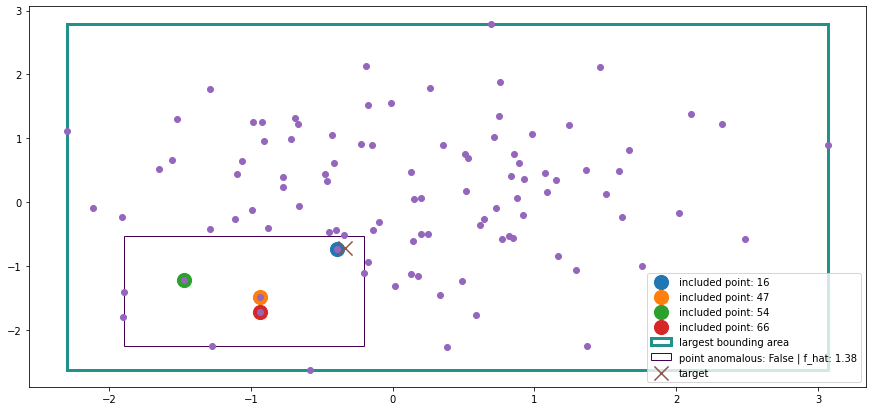

------- itr: 1 -------
area_calculated_pattern:  2.948427276218181


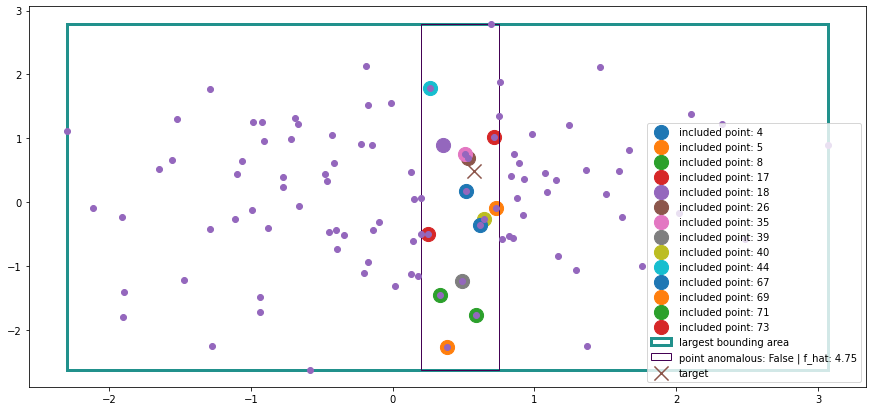

------- itr: 2 -------
area_calculated_pattern:  3.4666739188787146


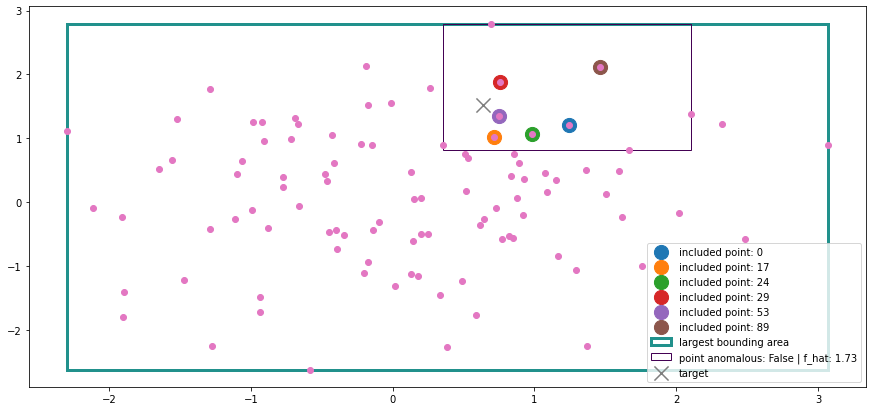

------- itr: 3 -------
area_calculated_pattern:  3.9708539421023294


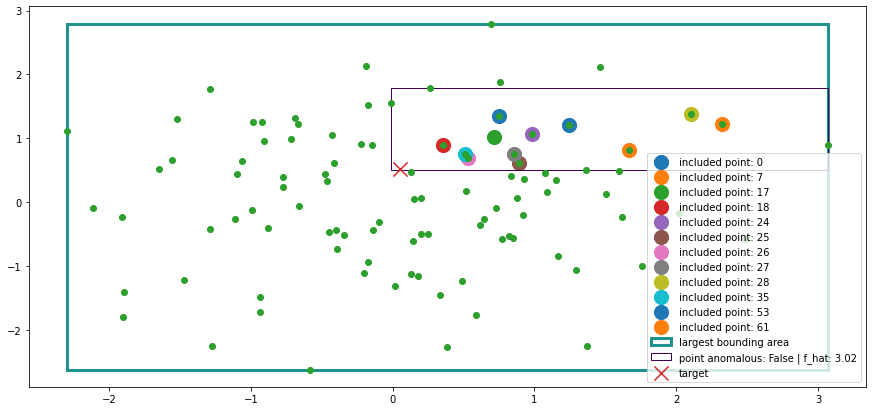

------- itr: 4 -------
area_calculated_pattern:  3.132702405281132


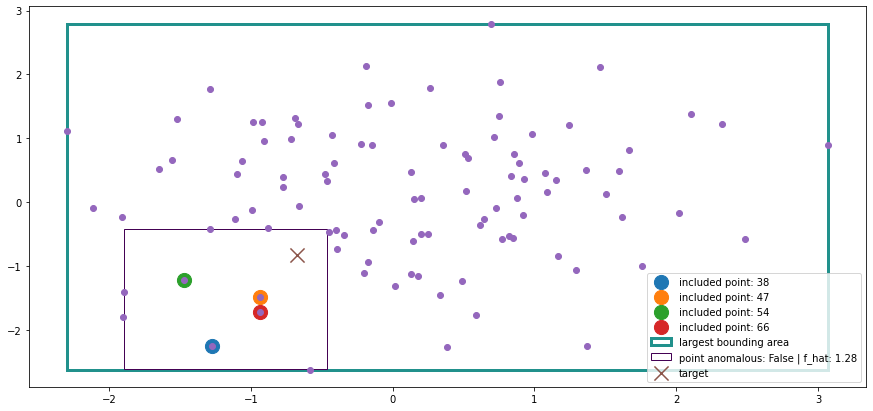

------- itr: 5 -------
area_calculated_pattern:  3.173647313430764


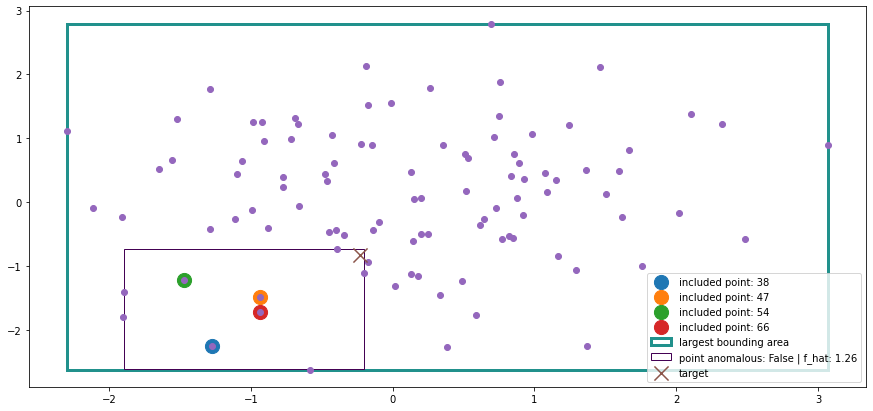

------- itr: 6 -------
area_calculated_pattern:  2.960781433587367


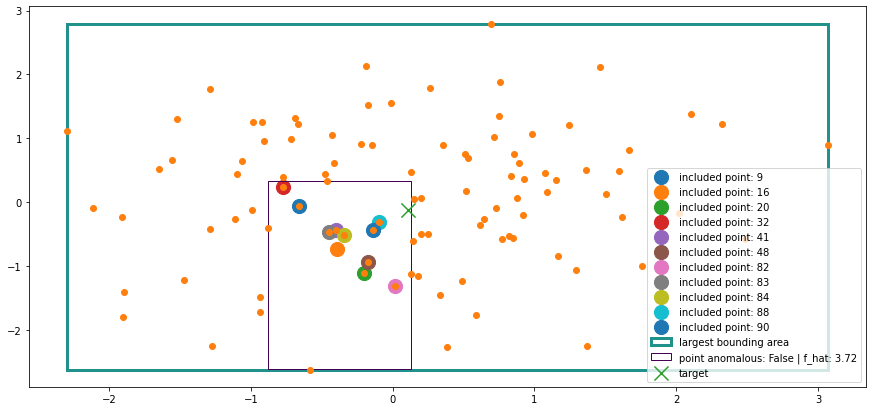

------- itr: 7 -------
area_calculated_pattern:  3.239434561742776


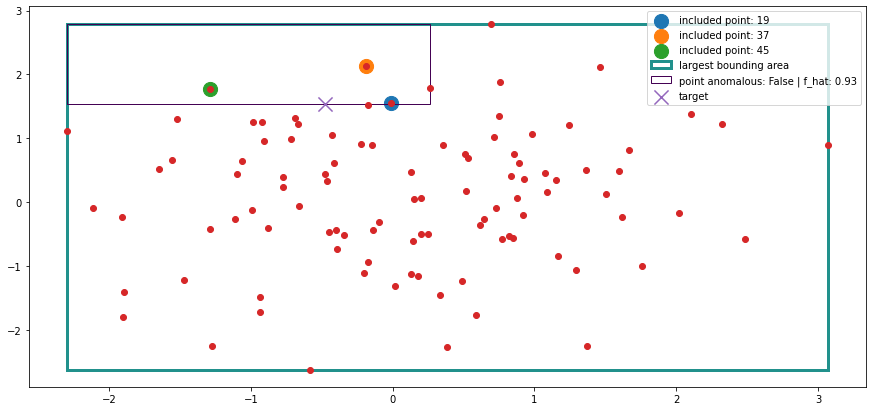

------- itr: 8 -------
area_calculated_pattern:  2.93690647213185


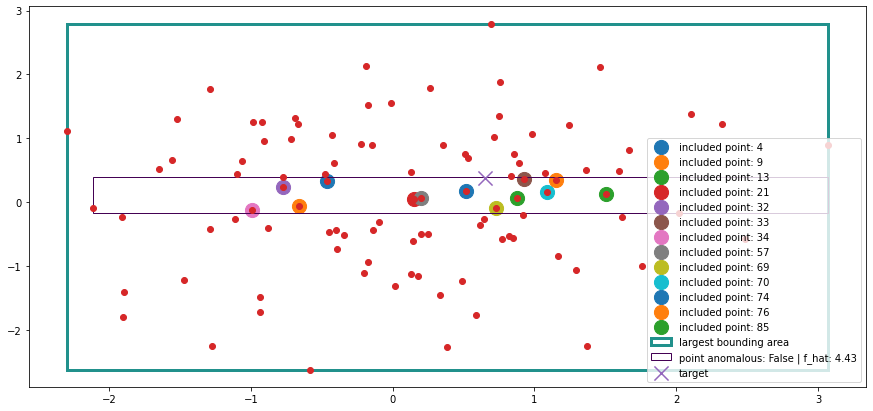

------- itr: 9 -------
area_calculated_pattern:  2.972248929533057


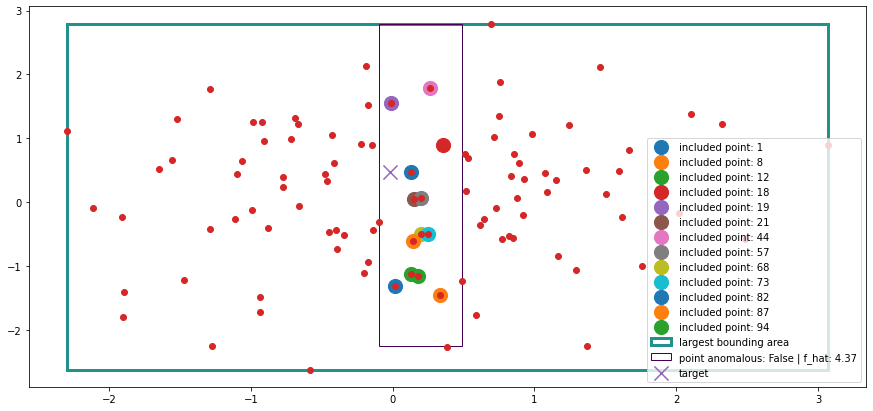

------- itr: 10 -------
area_calculated_pattern:  3.443034200087783


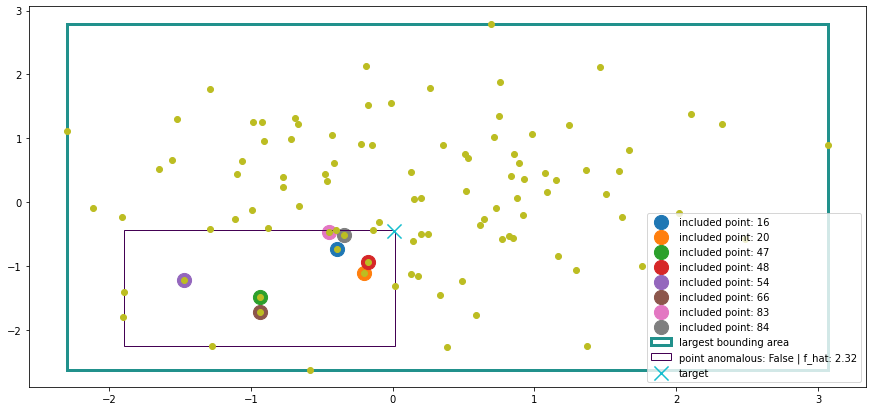

------- itr: 11 -------
area_calculated_pattern:  2.982228257524603


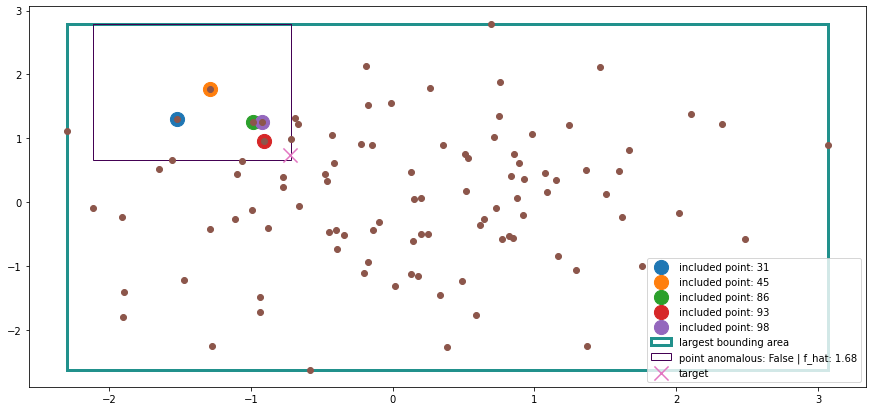

------- itr: 12 -------
area_calculated_pattern:  2.9291129161929828


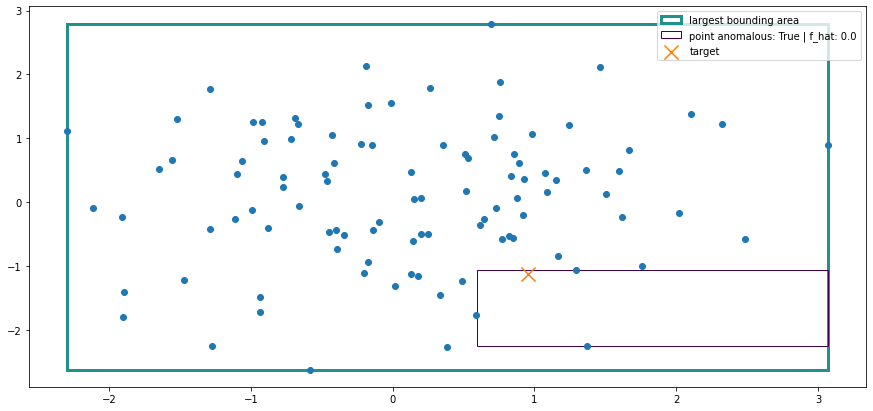

------- itr: 13 -------
area_calculated_pattern:  4.2059873496890665


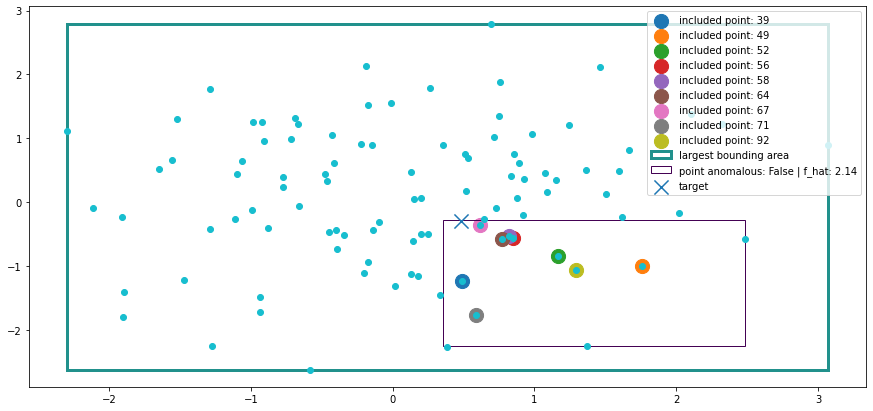

------- itr: 14 -------
area_calculated_pattern:  2.9611236282726


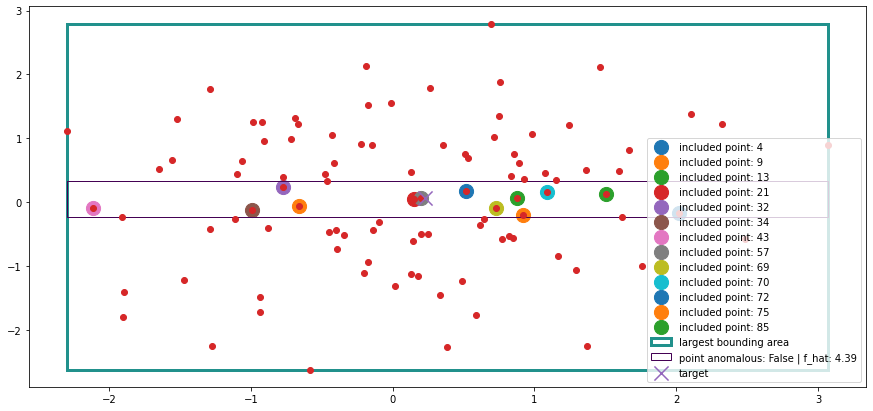

------- itr: 15 -------
area_calculated_pattern:  2.9611236282725604


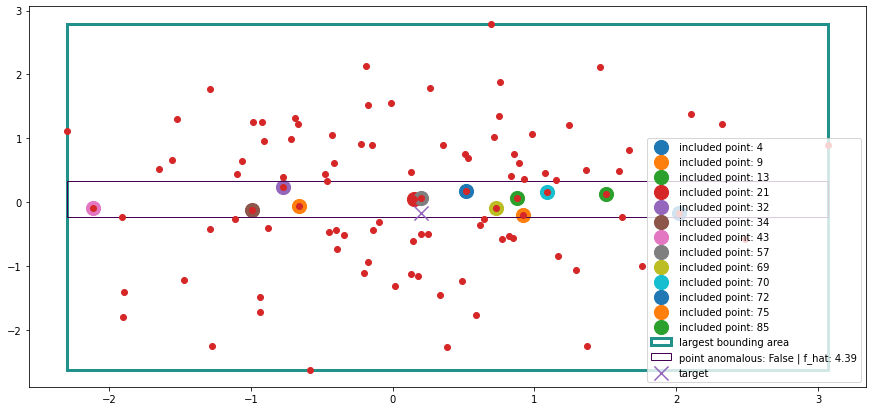

------- itr: 16 -------
area_calculated_pattern:  4.051267198717151


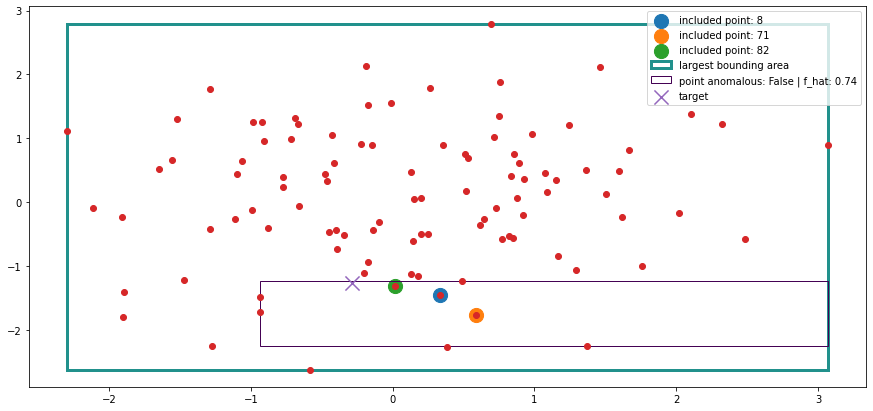

------- itr: 17 -------
area_calculated_pattern:  3.5008509153869465


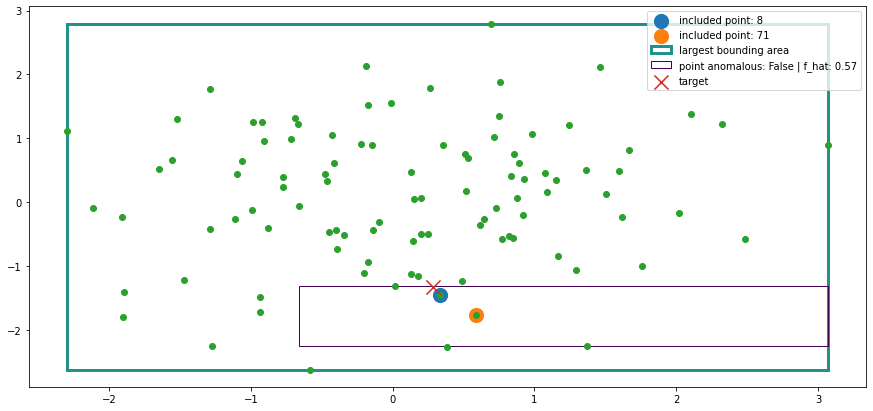

------- itr: 18 -------
area_calculated_pattern:  3.6083825280562203


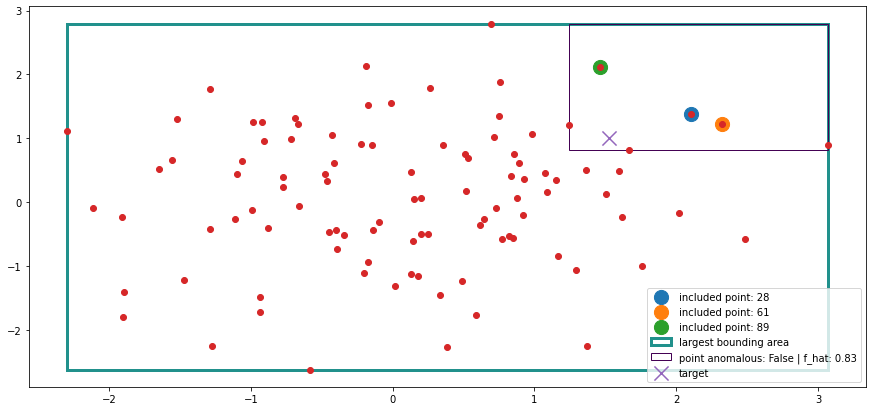

------- itr: 19 -------
area_calculated_pattern:  2.942963331860942


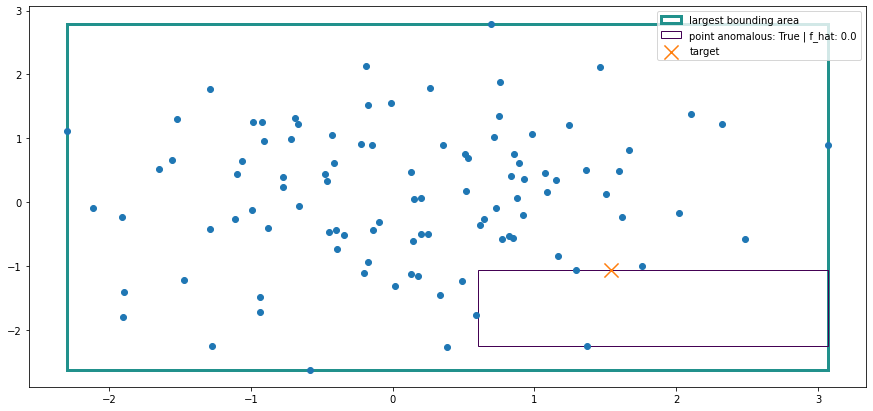

-- END __
Points that lie outside of the largest bounding area defined by the training set:  0
indices of the points:  []


In [99]:
plt.rcParams["figure.figsize"] = (15,7)

points_outside_of_largest_bounding_area = 0
indeces = []
predictions = []
mu = 0.1
lba = np.array(
    [
        [np.min(training_set[:, 0]), np.min(training_set[:, 1])],
        [np.max(training_set[:, 0]), np.max(training_set[:, 1])],
    ]
)
# This is just a guess that delivers mixed "acceptable" results (predictions)
#min_area = 2.0 # 0.1 # 
min_area = np.prod(np.apply_along_axis(lambda i: i[1] - i[0], axis=0, arr=lba)) / np.sqrt(len(training_set))
assert min_area > 0, "min area of largest bounding area is negative"
print("min_area: ", min_area)


for i, point_to_be_classified in enumerate(testing_set):
    ## 
    print(f"------- itr: {i} -------")

    pattern_space =  PatternSpace(
        type = PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
        cutoff = min_area
    )
    
    minlp_model, classification_result = minlp_has_rare_pattern(
        point_to_be_classified,
        training_set,
        pattern_space,
        mu,
        debugging_minlp_model=False,
    )

    predictions.append(classification_result)
    ax = plt.gca()
    
    if minlp_model is not None:
        result = (
            min_area,
            mu,
            classification_result,
            minlp_model
        )
        included_points = minlp_model.extract_points_included_in_pattern()
        calculated_pattern = minlp_model.extract_pattern()
        area_calculated_pattern = np.prod(np.apply_along_axis(lambda i: i[1] - i[0], axis=1, arr=calculated_pattern))
        print("area_calculated_pattern: ", area_calculated_pattern)
        assert area_calculated_pattern > 0, "area of minimized pattern is negative"
        largest_bounding_area = minlp_model.largest_bounding_area
        [plt.scatter(
            x=p[0], 
            y=p[1], 
            marker="o", 
            s=200, 
            label=f"included point: {np.argwhere(training_set == p)[0,0]}") for _, p in enumerate(included_points)
        ]
        
        plt.legend([f"area of calculated pattern: {area_calculated_pattern}"])
        draw_largest_bounding_area(largest_bounding_area.T, ax)
        draw2dpattern(calculated_pattern, ax, classification_result, minlp_model.minimized_f_hats, len(training_set))
        plt.legend(bbox_to_anchor=(1.1, 1.1))
    else:
        print(f"minlp model is none and classification results: {classification_result}")
        draw_largest_bounding_area(lba.T, ax)
        ax.legend()
        points_outside_of_largest_bounding_area += 1 
        indeces.append(i)

    plt.scatter(x=training_set[:,0], y=training_set[:,1])
    plt.scatter(
        x=point_to_be_classified[0], 
        y=point_to_be_classified[1], 
        marker="x",  
        s=200, 
        label="target") 
    # ax.title()
    plt.legend()
    plt.show()

print("-- END __")
print("Points that lie outside of the largest bounding area defined by the training set: ",points_outside_of_largest_bounding_area) 
print("indices of the points: ", indeces)

# Testing RarePatternDetect class

In [100]:
rpd = RarePatternDetect(
    delta=0.1,
    tau=0.05,
    epsilon=0.1,
    pattern_space = PatternSpace(
        PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
        cutoff= min_area
    )
)
rpd.load_training_data(training_set)
preds = [rpd.is_anomalous(point_to_be_classified) for _, point_to_be_classified in enumerate(testing_set)]

In [101]:
# -> should get the same results
# @TODO: add assert preds in np.array([True, False]) and no "None"
assert None not in preds 
assert None not in predictions
assert preds == predictions

In [102]:
predictions

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

# Experiment: comparing with Isolation Forest

In [103]:
from sklearn.ensemble import IsolationForest

X = training_set
clf = IsolationForest(random_state=0).fit(X)
r = clf.predict(testing_set) # -1 anomalie
r = np.where(r==1, r, False).astype(bool)
count_similar_predictions = np.count_nonzero(r == preds)
per_similar_predictions = count_similar_predictions/len(training_set)
count_similar_predictions,  per_similar_predictions


(1, 0.01)

In [104]:
# Notes: 
        # There is still an error that happens sometimes ... model should never return None as a prediction
            # -> can be fixed by setting a very small min_area, which leads to all points being labeled as anomaleous
        # why are all the points classified as anomalous? 
            #  -> f_hat is zero -> model able to find a pattern -> require bigger min_area?
                # -> DONE: tried some stuff out to get mixed classification results
                    # -> sqrt(number_of_training_points) give a mixed classification 
                        # (some patterns contain points from the training set. 
                        # Therefore, f_hat might be bigger. 
                        # Hence, the point is anomalous)

    # -> honestly maybe a circle in 2D as a pattern might make more sense of this 

# @Done: transfer to python files and call the model through the RarePatternDetect(.ipynb -> .py) and refactor
# @Ongoing: wrapping up the tests